In [ ]:
!pip install transformers torch scikit-learn xgboost

In [ ]:
import torch
import pandas as pd
import numpy as np
import re
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

In [ ]:
#load datasets
df = pd.read_csv("sample_data/iphone.csv")
df['reviewText'] = df['reviewTitle'].fillna('') + " " + df['reviewDescription'].fillna('')
df['sentiment'] = df['ratingScore'].apply(lambda x: 1 if x >= 4 else 0)

# Pastikan dataset memiliki kolom 'reviewText' dan 'sentiment'
df = df.dropna(subset=['reviewText', 'sentiment'])

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
# Isi missing values dengan teks default (jika ada kolom lain yang relevan)
df.fillna("", inplace=True)
df = df.dropna(subset=['reviewText', 'sentiment'])

# Encode label (misalnya: 'positif' → 1, 'negatif' → 0)
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [ ]:
before_counts = df['sentiment'].value_counts()

In [ ]:
# Bagi dataset menjadi train dan test
train_texts, _, train_labels, _ = train_test_split(
    df['reviewText'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42
)

In [ ]:
#load tokenizer & model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")

#ekstraksi fitur
def extract_features(text_list):
    tokens = tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state[:, 0, :].numpy()  # Mengambil embedding dari CLS token

# Konversi teks menjadi fitur
train_features = np.array([extract_features([text]) for text in train_texts])
train_features = train_features.reshape(train_features.shape[0], -1)  # Reshape untuk input XGBoost

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<ipython-input-17-f573abdf92ee>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=before_counts.index, y=before_counts.values, ax=axes, palette=['red', 'green'])


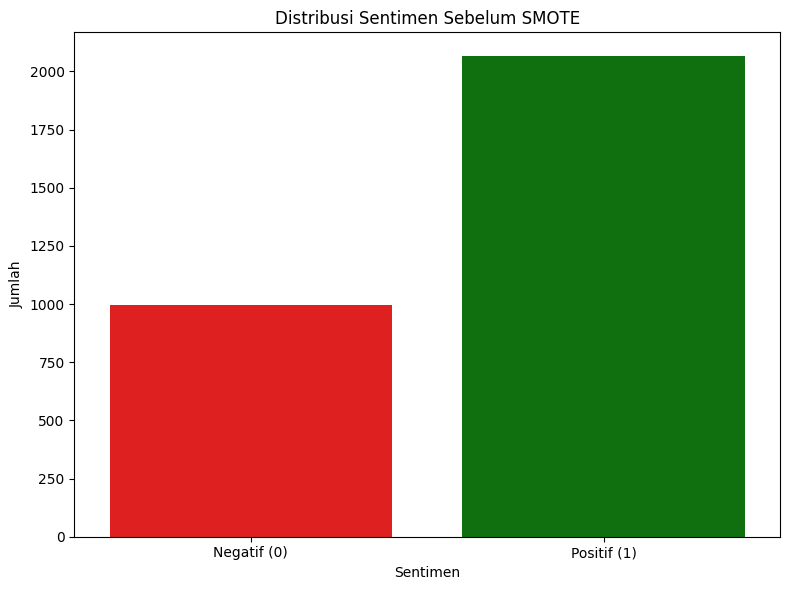

In [ ]:
fig, axes = plt.subplots(figsize=(8, 6))

sns.barplot(x=before_counts.index, y=before_counts.values, ax=axes, palette=['red', 'green'])
axes.set_title("Distribusi Sentimen Sebelum SMOTE")
axes.set_xlabel("Sentimen")
axes.set_ylabel("Jumlah")
axes.set_xticks([0, 1])
axes.set_xticklabels(["Negatif (0)", "Positif (1)"])

plt.tight_layout()
plt.show()

In [ ]:
#training xgboost
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_clf.fit(train_features, train_labels)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=42
)

#evaluasi model
train_preds = xgb_clf.predict(train_features)

# Assuming 'test_features' and 'test_labels' are your test data
y_pred = xgb_clf.predict(test_features)
y_test = test_labels

print("\nXGBoost Accuracy on Training Data:", accuracy_score(train_labels, train_preds))
print("XGBoost Classification Report on Training Data:\n", classification_report(train_labels, train_preds))


XGBoost Accuracy on Training Data: 0.9974476773864216
XGBoost Classification Report on Training Data:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       652
           1       1.00      1.00      1.00      1307

    accuracy                           1.00      1959
   macro avg       1.00      1.00      1.00      1959
weighted avg       1.00      1.00      1.00      1959



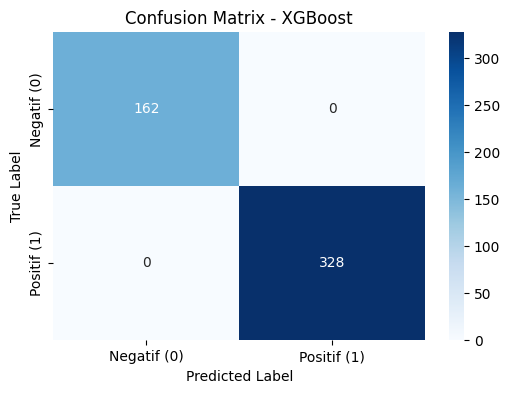

In [ ]:
plt.figure(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negatif (0)", "Positif (1)"], yticklabels=["Negatif (0)", "Positif (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()